# Geoprocessing Tutorial

I've developed this tutorial to help out people get a first contact with geoprocessing. There are two types of data we can handle with geoprocessing, one is a raster dataset and the other is a vector dataset. To handle raster data, we need to use the [rasterio](https://rasterio.readthedocs.io) library. To handle vector data, we need to use the [geopandas](https://geopandas.org) library.

# Table of Contents

1. [Introduction](#introduction)
2. [Getting Started](#getting-started)
3. [Geoprocessing with Python](#geoprocessing-with-python)
4. [Last Notes](#last-notes)

# Introduction

Before running this tutorial, I highly recommend you have a basic understanding of Python and the basics of geoprocessing. I'll be using geopandas to do the geoprocessing, but you can use any library that supports geoprocessing. I'll be using the [Portugal's Portal de dados abertos da Administração Pública](https://dados.gov.pt/) and [Plataforma de dados abertos georreferenciados da Câmara Municipal de Lisboa](https://geodados-cml.hub.arcgis.com/) as the source of data for this tutorial.

# Getting Started

To start we will be using data of house locations from [REMAX]() and [ImmoVirtual](). There might be some overlap between the datasets, but for the purpose of this tutorial, we will ignore it. The data has been extracted from the websites and can be found in the [data folder](./data/) of this tutorial.

We need to differentiate between two data types. One is a vector and another a raster. The vector data is a collection of points, lines, polygons, etc. The raster data is a collection of pixels. To work with raster data, we need to use the rasterio library. To work with vector data, we need to use the geopandas library. The house data in this case is made of Point vector data.

In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gpd

# Data to Read
house_data = pd.read_csv(Path("data", "house_data.csv"))
house_data_gdf = gpd.GeoDataFrame(house_data, geometry=gpd.points_from_xy(house_data.longitude, house_data.latitude), crs="epsg:4326").to_crs(epsg=3857)
house_data_gdf.head()

,house_id,bathrooms,rooms,price_per_m2,location,longitude,latitude,geometry
0,0,2.0,3,4760.714286,"Benfica, Lisboa",-9.195299,38.738027,POINT (-1023615.958 4684215.350)
1,1,2.0,3,2087.771623,"Casal de Cambra, Sintra, Lisboa",-9.230770,38.800521,POINT (-1027564.594 4693138.021)
2,2,3.0,4,5477.707006,"Parque das Nações, Lisboa",-9.095373,38.763871,POINT (-1012492.280 4687904.367)
3,3,1.0,2,3437.500000,"Carnaxide e Queijas, Oeiras, Lisboa",-9.244179,38.726096,POINT (-1029057.289 4682512.780)
4,4,1.0,2,2833.333333,"Águas Livres, Amadora, Lisboa",-9.220437,38.745552,POINT (-1026414.391 4685289.397)


## Adding Parish

Geopandas allows reading shapefile and geojson files direcly into a geopandas dataframe. But there is also the possibility to create geopandas dataframes from scratch in a similar way to pandas dataframes. We will open a shapelfile and some geojson files.

In [2]:
# URL from Portuguese Government with the Parish information data
parishes_url = "zip+https://dados.gov.pt/s/resources/freguesias-de-portugal/20181112-195834/cont-aad-caop2017.zip"
parishes_all = gpd.read_file(parishes_url).to_crs(epsg=3857)
parishes = parishes_all.loc[lambda d: d.Concelho == "LISBOA", ["Freguesia", "geometry"]]
parishes.head()

,Freguesia,geometry
617,Estrela,"POLYGON ((-1019044.243 4680957.588, -1019029.0..."
618,Misericórdia,"POLYGON ((-1017842.628 4680937.977, -1017839.2..."
621,Santa Maria Maior,"POLYGON ((-1016824.066 4681491.899, -1016823.9..."
622,Belém,"POLYGON ((-1023402.696 4678872.910, -1023400.9..."
624,São Vicente,"POLYGON ((-1014729.890 4681478.854, -1014012.1..."


We will join the parishes to the house data

In [3]:
house_data_gdf = gpd.sjoin(house_data_gdf, parishes, how="left", predicate="within").drop(columns=["index_right"]).loc[lambda d: d.Freguesia.notna()]
house_data_gdf.head()

,house_id,bathrooms,rooms,price_per_m2,location,longitude,latitude,geometry,Freguesia
0,0,2.0,3,4760.714286,"Benfica, Lisboa",-9.195299,38.738027,POINT (-1023615.958 4684215.350),Benfica
2,2,3.0,4,5477.707006,"Parque das Nações, Lisboa",-9.095373,38.763871,POINT (-1012492.280 4687904.367),Parque das Nações
5,5,2.0,2,6547.619048,"Alcântara, Lisboa",-9.182876,38.711057,POINT (-1022233.072 4680367.123),Alcântara
7,7,3.0,2,8952.380952,"Campo de Ourique, Lisboa",-9.165223,38.718213,POINT (-1020267.929 4681387.961),Campo de Ourique
8,8,1.0,1,8270.833333,"Avenidas Novas, Lisboa",-9.149825,38.736436,POINT (-1018553.851 4683988.337),Avenidas Novas


## Adding # Hospitals in 1Km Radius

In [4]:
# Public Hospitals in Lisbon
hospitals_url = "https://opendata.arcgis.com/datasets/172678f193144512860a397fde991361_4.geojson" # GeoJSON
hospitals_gdf = gpd.read_file(hospitals_url).to_crs(epsg=3857)
hospitals_gdf.head()

,OBJECTID,COD_SIG,IDTIPO,INF_NOME,INF_MORADA,INF_TELEFONE,INF_FAX,INF_EMAIL,INF_SITE,INF_DESCRICAO,INF_FONTE,INF_MUNICIPAL,GlobalID,geometry
0,1,2400701054001,2,Hospital São José,Rua José António Serrano,+351 218 841 000,None,sec.ca@chlc.min-saude.pt,http://www.chlc.min-saude.pt,Centro Hospitalar Lisboa Central,http://www.portaldasaude.pt/portal/servicos/pr...,0,7d8df448-70de-48a6-b0b7-1d1f8d6d9e5b,POINT (-1017176.155 4681318.976)
1,2,5000607001001,2,Maternidade Dr. Alfredo da Costa,"Rua Pinheiro Chagas, 5-5A\nRua Latino Coelho, ...",+351 213 184 000,None,secretariadoca@mac.min-saude.pt,http://www.mac.min-saude.pt,"Centro Hospitalar de Lisboa Central, EPE.\nO D...",http://www.portaldasaude.pt/portal/servicos/pr...,0,a3f158af-2e0b-4c47-9755-b52ca84b9a5f,POINT (-1018288.319 4683444.157)
2,3,1401401124001,2,Hospital Santa Marta,"Rua de Santa Marta, 50-50 I\n",+351 213 594 000,None,administracao@hsmarta.min-saude.pt,http://www.hsmarta.min-saude.pt/,Centro Hospitalar Lisboa Central,http://www.portaldasaude.pt/portal/servicos/pr...,0,6f870110-c10c-43ae-8c5e-0e3fdca17c36,POINT (-1018000.526 4682183.368)
3,4,4200102060001,2,Hospital Júlio de Matos,"Avenida do Brasil, 53-53D (Pav 11)\n",+351 217 917 000,None,administracao@chpl.min-saude.pt,http://www.hjmatos.min-saude.pt/,Centro Hospitalar Psiquiátrico de Lisboa,www.min-saude.pt/portal/servicos/prestadoresV2...,0,8518aec7-9050-4979-af83-38b3f0f4ee42,POINT (-1018144.090 4686940.843)
4,5,2303302109001,2,Hospital Curry Cabral,"Rua da Beneficência, 8\n\n",+351 217 924 200,None,cadm@hccabral.min-saude.pt,http://www.chlc.min-saude.pt,"Centro Hospitalar de Lisboa Central, EPE.\nO D...",http://www.portaldasaude.pt/portal/servicos/pr...,0,e2eb640d-ae60-450a-aee2-0c1dc666af33,POINT (-1018801.617 4684685.229)


In [5]:
# Buffer
house_data_gdf_buffer = (
    house_data_gdf
    .copy()
    .assign(geometry_buffer = lambda d: d.buffer(1000))
    .set_geometry("geometry_buffer")
)

# To get the a statistic of a geometry within another geometry, we can use a spatial join and then aggregate the values
house_data_gdf["hospitals_in_1km"] = (gpd.sjoin(house_data_gdf_buffer, hospitals_gdf, how="left", predicate="contains")
    .groupby("house_id", as_index=False)
    .agg({"OBJECTID": "count"})
    .rename(columns={"OBJECTID":"Hospitals"})
    .loc[:, "Hospitals"]
)

**Note:**
A very important thing when creating our own geopandas dataframes is to specify the right geometry and crs. Most of the times, we get latitude and longitude data, which we can easily convert to a Point geometry. With latitude and longitude, the crs is the WGS84 crs. But sometimes, we get data in a different crs. We should be careful to pay attention to the crs of our data.

## Adding Distance to closest Metro

In [6]:
# Read the data
metro = pd.read_csv(Path("data", "metro_stations.csv"))
# Convert to a GeoDataFrame
metro = gpd.GeoDataFrame(metro, geometry=gpd.points_from_xy(metro.longitude, metro.latitude), crs="epsg:4326").to_crs(epsg=3857)
# Get the closest metro station to each house
closest_metros = gpd.sjoin_nearest(house_data_gdf, metro, how="left").loc[:, ["latitude_right", "longitude_right"]]
# Convert the closest metro location to a geometry
house_data_gdf["closest_metro"] = gpd.points_from_xy(closest_metros.longitude_right, closest_metros.latitude_right, crs="epsg:4326").to_crs(epsg=3857)
# Calculate the distance to the closest metro station
house_data_gdf = house_data_gdf.assign(metro_distance=house_data_gdf.distance(house_data_gdf.closest_metro, align=True))

## Properties of a GeoDataFrame

There are two very important properties of geodataframes. The first is the geometry column. This column contains the geometry of each row. The second is the crs property. This property contains the coordinate reference system of the dataframe. The geometry is very similar to a column or Series in pandas, but with geometric data, therefore named [GeoSeries](https://geopandas.org/en/stable/docs/reference/geoseries.html). The objects within the geometry column are of type [shapely.geometry.base.BaseGeometry](https://shapely.readthedocs.io/en/stable/manual.html#geometry-types). We can visualize their shape by plotting them, or simply by printing them.

* By using the `plot()` method, we can visualize the geometry of the dataframe.
* The geometry column can be accessed by using the `geometry` property. It is a `GeoSeries` and doesn't necessarily have the name of "geometry".
* It is possible to have multiple `GeoSeries` in a `GeoDataFrame` but all geometric operations done on a `GeoDataFrame` are performed only on the geometry column.

<AxesSubplot:>

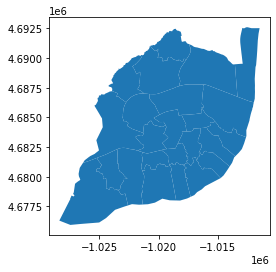

In [8]:
parishes_all[parishes_all.Concelho=="LISBOA"].plot()

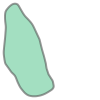

In [9]:
# Parishes have a Polygon type of geometry
parishes_all.geometry.iloc[0]

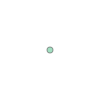

In [10]:
# Both hospital and ctt data have the same type of geometry (Point)
house_data.geometry.iloc[0]

The CRS is a [proj4](https://proj4.org/operations/projections/) string that defines the coordinate reference system of the dataframe. It is very similar to the [crs](https://rasterio.readthedocs.io/en/latest/api/rasterio.crs.html) property of rasterio. The CRS is used to convert the coordinates of the geometry column to the desired coordinate reference system. The most common CRS is the [EPSG:4326](https://epsg.io/4326) which is in the WGS84 coordinate reference system. The CRS can be accessed by using the `crs` property in a `GeoDataFrame`.

In [11]:
house_data_gdf.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

If we will work with multiple geodataframes, we will need to make sure that they have the same CRS. In the case we are working on a city level, we can use a Projected Coordinate System instead of the WGS84. 

## Adding Elevation

Elevation is usually raster data and to read it, we can use the rasterio library. Raster data is a collection of pixels. The pixels are represented by a grid of values. The values are represented by a [numpy array](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html). Usually raster data is stored in a [GeoTIFF](https://en.wikipedia.org/wiki/Geographic_Information_Model) file. it is also possible to read raster data from a [GDAL](https://gdal.org/) file. 

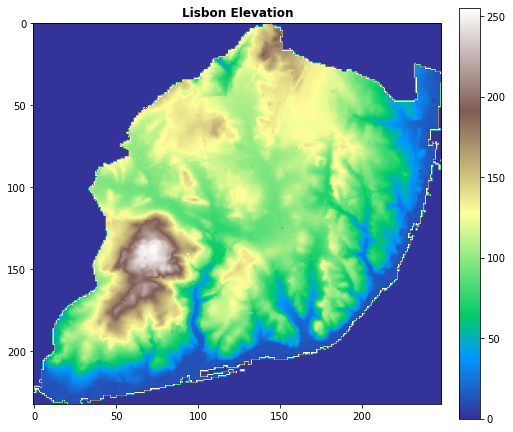

In [12]:
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, figsize=(8, 8))

url = "zip+file:data/mdt.zip!mdt.tif"
lisbon_elevation = rasterio.open(url)
i = ax.imshow(lisbon_elevation.read_masks(1), cmap='terrain')
show(lisbon_elevation,  cmap="terrain", title="Lisbon Elevation", ax=ax, with_bounds=False)
plt.colorbar(i, fraction=0.046, pad=0.04)

In [13]:
# Get the elevation of each house
house_data_gdf["elevation"] = house_data_gdf.to_crs(lisbon_elevation.crs).geometry.apply(lambda x: next(lisbon_elevation.sample([(x.x, x.y)]))[0])
house_data_gdf.head()

,house_id,bathrooms,rooms,price_per_m2,location,longitude,latitude,geometry,Freguesia,hospitals_in_1km,closest_metro,metro_distance,elevation
0,0,2.0,3,4760.714286,"Benfica, Lisboa",-9.195299,38.738027,POINT (-1023615.958 4684215.350),Benfica,0.0,POINT (-1022870.428 4686416.631),2324.102440,159.569717
2,2,3.0,4,5477.707006,"Parque das Nações, Lisboa",-9.095373,38.763871,POINT (-1012492.280 4687904.367),Parque das Nações,0.0,POINT (-1012932.503 4688511.820),750.197241,5.000000
5,5,2.0,2,6547.619048,"Alcântara, Lisboa",-9.182876,38.711057,POINT (-1022233.072 4680367.123),Alcântara,0.0,POINT (-1019036.317 4681687.331),3458.639299,61.351177
7,7,3.0,2,8952.380952,"Campo de Ourique, Lisboa",-9.165223,38.718213,POINT (-1020267.929 4681387.961),Campo de Ourique,2.0,POINT (-1019036.317 4681687.331),1267.473190,91.776711
8,8,1.0,1,8270.833333,"Avenidas Novas, Lisboa",-9.149825,38.736436,POINT (-1018553.851 4683988.337),Avenidas Novas,0.0,POINT (-1018890.590 4683773.393),399.492430,73.785683


# Geoprocessing with Python

There are multiple other processing methods that can be used to perform geoprocessing. I will provide a few extra examples, but there are many more. I will be using the [geopandas](https://geopandas.org/en/stable/index.html) library's available methods.

1. Union between different parishes
2. Summarize within Lisbon's parishes, the number of public hospitals in the dataset
4. Get the maximum elevation in a Lisbon parish

## Union between different parishes

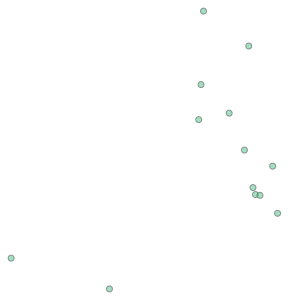

In [14]:
# We can join a whole GeoSeries into one object
hospitals_gdf.geometry.unary_union

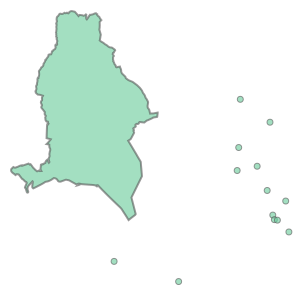

In [21]:
# We are aggregating (dissolve()) all parishes into a single geometry, and joining (union()) with the Point geometries of the hospitals.
parishes_all[parishes_all.Concelho=="AMADORA"].dissolve().union(hospitals_gdf.geometry.unary_union).iloc[0]

## Summarize Within

In [22]:
# To get the a statistic of a geometry within another geometry, we can use a spatial join and then aggregate the values
gpd.sjoin(hospitals_gdf, parishes, how="inner", predicate="within")\
    .groupby("Freguesia", as_index=False)\
    .agg({"OBJECTID": "count"})\
    .rename(columns={"OBJECTID":"Hospitals"})\
    .style.background_gradient(cmap="Blues")

,Freguesia,Hospitals
0,Alcântara,1
1,Alvalade,2
2,Arroios,2
3,Avenidas Novas,2
4,Belém,1
5,Lumiar,1
6,Santo António,3
7,São Domingos de Benfica,1


## Masking a Raster and Getting Max Elevation

In [23]:
from rasterio.mask import mask

# We use mask to create a mask of the raster with the geometry of a specific parish. This allows me to get the maximum elevation in the parish.
print("Max elevation in Parque das Nações:", mask(lisbon_elevation, parishes[parishes.Freguesia == "Parque das Nações"].geometry.to_crs(lisbon_elevation.crs), crop=True)[0].max())

Max elevation in Parque das Nações: 42.117237


# Autocorrelation Analysis

We will use [Pysal](https://pysal.readthedocs.io/en/latest/) to calculate the autocorrelation of the house prices. This should give a quick insight of the capabilities of running statistics on geographical data.

In [25]:
final_house_data = house_data_gdf.drop(columns=["geometry", "closest_metro"])
gdf = gpd.GeoDataFrame(final_house_data, geometry=gpd.points_from_xy(final_house_data.longitude, final_house_data.latitude), crs="epsg:4326").to_crs(epsg=3857)

In [26]:
from libpysal.weights import KNN

y = gdf['price_per_m2'].values
w = KNN.from_dataframe(gdf, k=1000)
w.transform = "r"

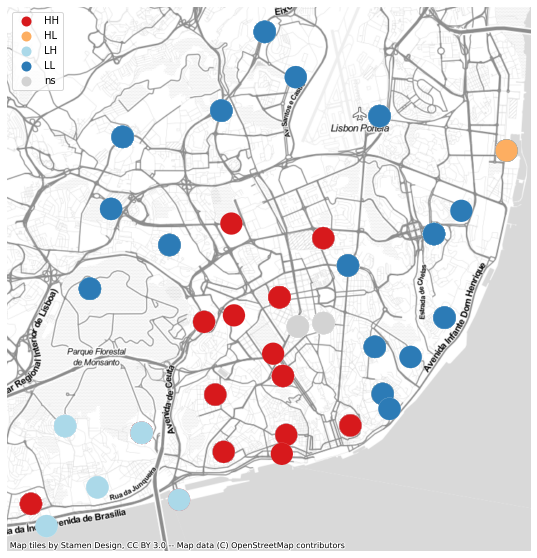

In [27]:
from splot.esda import lisa_cluster
from esda.moran import Moran_Local
import contextily as ctx

moran_loc = Moran_Local(y, w)
fig, ax = lisa_cluster(moran_loc, gdf, p=0.05, figsize = (10,10), markersize = 500, legend_kwds = {"loc": 'upper left'})
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
plt.show()

# Last Notes

I highly advise checking out the libraries that I used in this tutorial, in this case [rasterio](https://rasterio.readthedocs.io/en/latest/) and [geopandas](https://geopandas.org/). But there are many others that are used within these libraries or that offer a completely different approach such as the python [GDAL/OGR API](https://gdal.org).

I also quickly covered a great library for running autocorrelation analysis on geographical data, and this was done with [PySal](https://pysal.org/). This is a library that is built on top of many of the libraries that we used in this tutorial. Once you get the grasp of working with Geodataframes, you can use this library to perform even more statistical analysis.